In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, ExtendedDataset, evaluate_on_test, init_weights, save_obj, load_obj, remove_nan

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [4]:
# start from 1960
full.drop(columns=['A191RL1Q225SBEA'], inplace=True)
full = full.loc["1960-01-01":]
full = remove_nan(full)
print(full.shape)

INTDSRUSM193N
ISRATIO
MTSDS133FMS
T10Y2YM
USSLIND
GFDEGDQ188S
GS20
MCOILWTICO
TCU
TOTALSA
(709, 21)


In [5]:
class FeedforwardSixHidden(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(FeedforwardSixHidden, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.fc3 = nn.Linear(input_size, input_size)
        self.fc4 = nn.Linear(input_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, 3)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
    def forward(self, x):
        x_temp = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x + x_temp
        
        x = F.relu(self.fc4(x))
        x_temp = x
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = x + x_temp
        
        x = self.fc7(x)
        return x
    

In [6]:
trainer = TrainHelper(percent = 1, manual = 5000, print_every=1)

PATH = "./Extended Deep/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.input_size//full.shape[1]) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [7]:
length = len(full)
val_start = round(length * 0.8)
test_start = round(length * 0.9)
print(length)

709


In [21]:
losses = load_obj("FF_Extended_Deep")

In [ ]:
hiddens = [12, 24]

for lags in range(1, 6):
    data = ExtendedDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(data, [i for i in range(val_start - 1 - lags)])
    valset = Subset(data, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = FeedforwardSixHidden(lags * full.shape[1], hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

In [16]:
save_obj(losses, "FF_Extended_Deep")

In [30]:
lowest = 100000000

for k, v in losses.items():
    best_loss = v[np.argmin(v)]
    if best_loss < lowest:
        lowest = best_loss
        
lowest

0.11500501457485372

In [28]:
best_loss_12 = []
avg_loss_12 = []
best_loss_24 = []
avg_loss_24 = []

for k, v in losses.items():
    if k.split("-")[1] == str(12):
        best_net_index = np.argmin(v)
        best_loss_12.append(v[best_net_index])
        avg_loss_12.append(get_average(v))
    if k.split("-")[1] == str(24):
        best_net_index = np.argmin(v)
        best_loss_24.append(v[best_net_index])
        avg_loss_24.append(get_average(v))
    
best_loss = []
avg_loss = []

for i in range(len(best_loss_12)):
    best_loss.append((best_loss_12[i] + best_loss_24[i]) / 2)
    avg_loss.append((avg_loss_12[i] + avg_loss_24[i]) / 2)


Text(0, 0.5, 'Final Validation Loss')

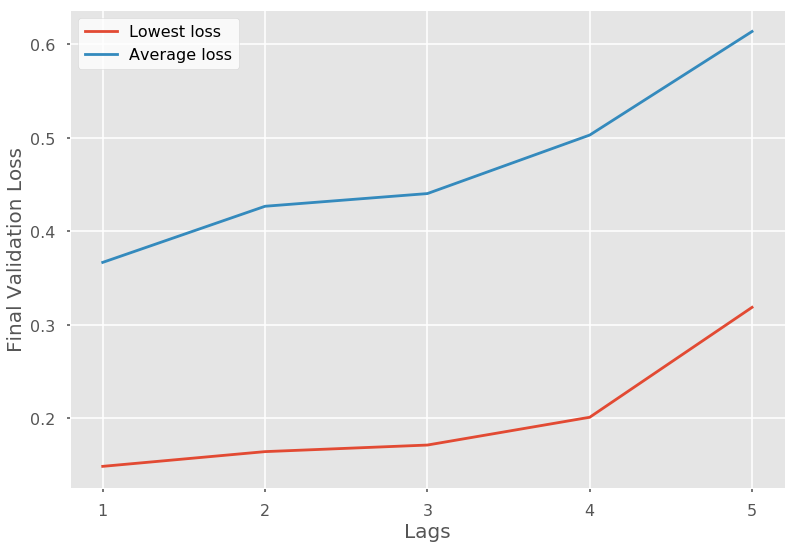

In [29]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss) + 1)], best_loss)
plt.plot([i for i in range(1, len(best_loss) + 1)], avg_loss)

plt.xticks([1, 2, 3, 4, 5])

plt.legend(("Lowest loss", "Average loss"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
# plt.savefig('../Figs/lags_deep_extended.png', bbox_inches='tight')

# Forecasts

In [8]:
from utils import count_parameters
from math import sqrt

In [9]:
losses = load_obj("FF_Extended_Deep")

In [10]:
# best model?
lowest = 100000000

for k, v in losses.items():
    best_index = np.argmin(v)
    best_loss = v[best_index]
    if best_loss < lowest:
        lowest = best_loss
        lowest_key = k
        lowest_index = best_index
        
print(lowest)
print(lowest_key)
print(lowest_index)

0.11500501457485372
2-12
3


In [11]:
lags = 2

testdata = ExtendedDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

testset = Subset(testdata, [i for i in range(test_start, length - lags)])

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

In [15]:
criterion = nn.MSELoss()

net = FeedforwardSixHidden(lags * full.shape[1], hidden_size=12)
# is actually lag * 7 because i made a mistake and calculated lag as input_size//3 when should be
# input_size//full.shape[1], and full.shape[1] == 21 == 7 * 3
net.load_state_dict(torch.load("Extended Deep/lag14hidden12_3.pt"))

In [16]:
y_pred, loss = evaluate_on_test(testloader, net, criterion)

In [17]:
sqrt(loss)

0.26270215645373174

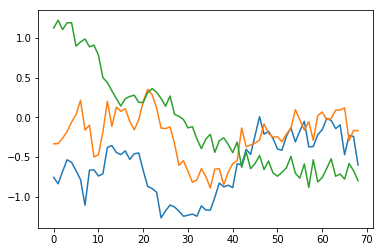

In [18]:
plt.plot(y_pred)

In [19]:
len(testloader)

69

In [20]:
save_obj(y_pred, "../Forecasts Extended/Deep")

In [21]:
count_parameters(net)

6285